# Case Study 2 - Fairness

## Imports
Lets import the required standard libraries and relevant Synthcity modules. We can also set the level of logging here. 

```TODO:```

```- Add Random seeds?```

```- Load normal version and handle horizon in notebook```

In [1]:
# Standard
import sys
import warnings
from pathlib import Path
from typing import Any, Tuple
from pprint import pprint

# 3rd party
import numpy as np
import pandas as pd
import networkx as nx
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, accuracy_score, confusion_matrix, ConfusionMatrixDisplay


# synthcity
import synthcity.logger as log
from synthcity.utils import serialization
from synthcity.plugins import Plugins
from synthcity.plugins.core.dataloader import (GenericDataLoader, SurvivalAnalysisDataLoader)
from synthcity.metrics import Metrics

# Configure warnings and logging
warnings.filterwarnings("ignore")

# Set the level for the logging
log.remove()
log.add(sink=sys.stderr, level="INFO")

/home/rob/miniconda3/envs/synth-lab/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load the data

In [2]:
X = pd.read_csv(f"../data/Brazil_COVID/covid_normalised_numericalised_classification.csv")
X.drop(columns=["is_dead", "Days_hospital_to_outcome"], inplace=True) # drop survival columns to frame it as a classification problem

# Define the mappings of the encoded values in the Ethnicity column to the understandable values
ethnicity_mapper = {
    0: "Mixed",
    1: "White",
    2: "Black",
    3: "East Asian",
    4: "Indigenous",
}

## The Problem

Lets train an XGBoost classifier on the whole dataset then test it on each ethnicity. This will show us that classifiers can perform worse on groups underrepresented in the training dataset.

In [ ]:
y = X["is_dead_at_time_horizon=14"]
X_in = X.drop(columns=["is_dead_at_time_horizon=14"])

X_train, X_test, y_train, y_test = train_test_split(X_in, y, random_state=4)
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

# Train model on whole dataset
xgb_model = xgb.XGBClassifier(
    n_estimators=2000,
    learning_rate=0.01,
    max_depth=5,
    subsample=0.8, 
    colsample_bytree=1, 
    gamma=1, 
    objective="binary:logistic",
    random_state=42,
)
xgb_model.fit(X_train, y_train)

ethnicity_idxes = X_in["Ethnicity"].unique()
ethnicity_idxes.sort()
ethnicities = [ethnicity_mapper[e] for e in ethnicity_idxes]

calculated_accuracy_score = accuracy_score(y_train, xgb_model.predict(X_train))
print(f"Evaluating accuracy on train set: {calculated_accuracy_score}")
y_pred = xgb_model.predict(X_test)
calculated_accuracy_score = accuracy_score(y_test, y_pred)


f, axes = plt.subplots(2, 3, figsize=(20, 10))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb_model.classes_)
disp.plot(ax=axes[0,0])
disp.ax_.set_title(f"Whole test dataset: {calculated_accuracy_score}")

for ethnicity_idx in ethnicity_idxes:
    X_test_per_ethnicity = X_test.loc[X_test["Ethnicity"] == ethnicity_idx]
    test_records_per_ethnicity_indicies = X_test_per_ethnicity.index

    y_pred = xgb_model.predict(X_test_per_ethnicity)
    y_true = y_test.iloc[test_records_per_ethnicity_indicies]

    calculated_accuracy_score = accuracy_score(y_true, y_pred)

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb_model.classes_)
    ax_index = [0, ethnicity_idx + 1] if ethnicity_idx <= 1 else [1, (ethnicity_idx + 1) % 3]
    disp.plot(ax=axes[ax_index[0], ax_index[1]])
    disp.ax_.set_title(f"Ethnicity: {ethnicity_mapper[ethnicity_idx]} | Performance: {calculated_accuracy_score}")
plt.show()

As you can see the performance of the model on the subpopulation whose ethnicity is Black is significantly worse than the overall performance. Interestingly, however the model performs better on the East Asian subpopulation. This is liely to be due to random chance, i.e. it happens that the East Asian patients had features that are good predictors of the outcome, but this would not necessarily be true for a bigger sample from the same population. The Indigenous population is so poorly represented in the dataset, with only 3 records, that it is difficult to even accurately assess performance. However, the indication we have from these threee records suggests performance may be poor.

# The solution - Augment the dataset to improve the fairness

First we load the data with the GenericDataLoader. For this we need to pass the names of our `target_column` to the data loader. Then we can see the data by calling loader.dataframe() and get the infomation about the data loader object with loader.info().


In [83]:
loader = GenericDataLoader(
    X,
    target_column="is_dead_at_time_horizon=14",
    sensitive_features=["Age", "Sex", "Ethnicity", "Region"],
    random_state=42,
)

display(loader.dataframe())
print(loader["Ethnicity"].value_counts())

,is_dead_at_time_horizon=14,Age,Sex,Ethnicity,Region,Fever,Cough,Sore_throat,Shortness_of_breath,Respiratory_discomfort,...,Vomitting,Cardiovascular,Asthma,Diabetis,Pulmonary,Immunosuppresion,Obesity,Liver,Neurologic,Renal
0,0,1,0,0,2,1,1,0,1,1,...,0,0,1,0,0,0,0,0,0,0
1,0,75,0,0,2,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,1,61,1,0,2,1,1,0,1,0,...,0,1,0,1,0,0,0,0,0,0
3,1,81,1,0,2,1,1,0,1,1,...,0,1,0,1,0,0,0,0,0,0
4,1,86,0,0,2,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6877,0,52,0,0,4,1,1,0,1,1,...,0,0,0,1,0,0,0,0,0,0
6878,0,34,1,1,4,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
6879,0,44,1,1,4,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
6880,0,23,1,1,4,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


1    4061
0    2229
2     443
3     137
4      12
Name: Ethnicity, dtype: int64


## Generate the synthetic data
```TODO: Explain cond```

In [67]:
prefix = "fairness.conditional_augmentation"
model = "ctgan"
count = 6882 # set the count equal to the number of rows in the original dataset
cond = [(i % 5) for i in range(count)] # set cond to an equal proportion of each index to encourage an equal a split as possible
print(model)

save_file = Path("saved_models") / f"{prefix}_{model}_numericalised.bkp"
if Path(save_file).exists():
    syn_model = serialization.load_from_file(save_file)
else:
    syn_model = Plugins().get(model)
    syn_model.fit(loader, cond=loader.dataframe()["Ethnicity"])
    serialization.save_to_file(save_file, syn_model)

syn_data = syn_model.generate(count=count, cond=cond).dataframe()
display(syn_data)
print("Here is the ethnicity breakdown for the new synthetic dataset:")
print(syn_data["Ethnicity"].value_counts().rename(ethnicity_mapper))

[2023-01-12T10:23:34.219146+0000][84885][INFO] Encoding is_dead_at_time_horizon=14 1869987325024176082
[2023-01-12T10:23:34.221076+0000][84885][INFO] Encoding Age 5659871819397669504
[2023-01-12T10:23:34.223068+0000][84885][INFO] Encoding Sex 3548374539502180407
[2023-01-12T10:23:34.225017+0000][84885][INFO] Encoding Ethnicity 1352749107489397983
[2023-01-12T10:23:34.226825+0000][84885][INFO] Encoding Region 1570994782263572838
[2023-01-12T10:23:34.229967+0000][84885][INFO] Encoding Fever 6136380213932958883
[2023-01-12T10:23:34.233142+0000][84885][INFO] Encoding Cough 8732296494109597033
[2023-01-12T10:23:34.236166+0000][84885][INFO] Encoding Sore_throat 8334218435351263310
[2023-01-12T10:23:34.239127+0000][84885][INFO] Encoding Shortness_of_breath 7461316199550560633
[2023-01-12T10:23:34.241931+0000][84885][INFO] Encoding Respiratory_discomfort 6138631581957096590
[2023-01-12T10:23:34.244426+0000][84885][INFO] Encoding SPO2 3566003324772400627
[2023-01-12T10:23:34.246664+0000][84885]

ctgan


 22%|██▏       | 449/2000 [01:13<04:12,  6.14it/s]


# Lets try our classifier again with the synthetic dataset

In [ ]:
syn_y = syn_data["is_dead_at_time_horizon=14"]
syn_X_in = syn_data.drop(columns=["is_dead_at_time_horizon=14"])

syn_X_train, syn_X_test, syn_y_train, syn_y_test = train_test_split(syn_X_in, syn_y, random_state=4)
syn_X_train.reset_index(drop=True, inplace=True)
syn_X_test.reset_index(drop=True, inplace=True)
syn_y_train.reset_index(drop=True, inplace=True)
syn_y_test.reset_index(drop=True, inplace=True)

# Train model on whole dataset
xgb_model = xgb.XGBClassifier(
    n_estimators=2000,
    learning_rate=0.01,
    max_depth=5,
    subsample=0.8, 
    colsample_bytree=1, 
    gamma=1, 
    objective="binary:logistic",
    random_state=42,
)
xgb_model.fit(syn_X_train, syn_y_train)

ethnicity_idxes = syn_X_in["Ethnicity"].unique()
ethnicity_idxes.sort()
ethnicities = [ethnicity_mapper[e] for e in ethnicity_idxes]

calculated_accuracy_score = accuracy_score(syn_y_train, xgb_model.predict(syn_X_train))
print(f"evaluating train set: {calculated_accuracy_score}")
syn_y_pred = xgb_model.predict(syn_X_test)
calculated_accuracy_score = accuracy_score(syn_y_test, syn_y_pred)


f, axes = plt.subplots(2, 3, figsize=(20, 10))

cm = confusion_matrix(syn_y_test, syn_y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb_model.classes_)
disp.plot(ax=axes[0,0])
disp.ax_.set_title(f"Whole Test Dataset | Performance: {calculated_accuracy_score}")

for ethnicity_idx in ethnicity_idxes:
    syn_X_test_per_ethnicity = syn_X_test.loc[syn_X_test["Ethnicity"] == ethnicity_idx]
    test_records_per_ethnicity_indicies = syn_X_test_per_ethnicity.index

    syn_y_pred = xgb_model.predict(syn_X_test_per_ethnicity)
    syn_y_true = syn_y_test.iloc[test_records_per_ethnicity_indicies]

    calculated_accuracy_score = accuracy_score(syn_y_true, syn_y_pred)

    cm = confusion_matrix(syn_y_true, syn_y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb_model.classes_)
    ax_index = [0, ethnicity_idx + 1] if ethnicity_idx <= 1 else [1, (ethnicity_idx + 1) % 3]
    disp.plot(ax=axes[ax_index[0], ax_index[1]])
    disp.ax_.set_title(f"Ethnicity: {ethnicity_mapper[ethnicity_idx]} | Performance: {calculated_accuracy_score}")
plt.show()

As you can see the new model trained on the synthetic data performs more similarly across the different populations.

# Removing bias via causal generation with DECAF
## Synthetic generators

We can list the available generic synthetic generators by calling list() on the Plugins object.

In [3]:
fairness_plugins = Plugins(categories=["fairness"]).list()
print(fairness_plugins)

['decaf']


### Load the data

In [4]:
X = pd.read_csv(f"../data/Brazil_COVID/covid_normalised_numericalised_classification.csv")
X.drop(columns=["is_dead", "Days_hospital_to_outcome"], inplace=True) # drop survival columns to frame it as a classification problem

loader = GenericDataLoader(
    X,
    target_column="is_dead_at_time_horizon=14",
    sensitive_features=["Age", "Sex", "Ethnicity", "Region"],
    random_state=42,
)

display(loader.dataframe())
print(X.columns)
print(len(X.columns))

,is_dead_at_time_horizon=14,Age,Sex,Ethnicity,Region,Fever,Cough,Sore_throat,Shortness_of_breath,Respiratory_discomfort,...,Vomitting,Cardiovascular,Asthma,Diabetis,Pulmonary,Immunosuppresion,Obesity,Liver,Neurologic,Renal
0,0,1,0,0,2,1,1,0,1,1,...,0,0,1,0,0,0,0,0,0,0
1,0,75,0,0,2,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,1,61,1,0,2,1,1,0,1,0,...,0,1,0,1,0,0,0,0,0,0
3,1,81,1,0,2,1,1,0,1,1,...,0,1,0,1,0,0,0,0,0,0
4,1,86,0,0,2,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6877,0,52,0,0,4,1,1,0,1,1,...,0,0,0,1,0,0,0,0,0,0
6878,0,34,1,1,4,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
6879,0,44,1,1,4,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
6880,0,23,1,1,4,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Index(['is_dead_at_time_horizon=14', 'Age', 'Sex', 'Ethnicity', 'Region',
       'Fever', 'Cough', 'Sore_throat', 'Shortness_of_breath',
       'Respiratory_discomfort', 'SPO2', 'Dihareea', 'Vomitting',
       'Cardiovascular', 'Asthma', 'Diabetis', 'Pulmonary', 'Immunosuppresion',
       'Obesity', 'Liver', 'Neurologic', 'Renal'],
      dtype='object')
22


## Generate synthetic data

### Create and fit syn_model using DECAF

In [8]:
prefix = "fairness.causal_generation"
model = "decaf"
n_iter = 201
count = 6882 # set the count equal to the number of rows in the original dataset
print(model)

save_file = Path("saved_models") / f"{prefix}_{model}_n_iter={n_iter}_numericalised.bkp"
if Path(save_file).exists():
    syn_model = serialization.load_from_file(save_file)
else:
    syn_model = Plugins().get(model, n_iter=n_iter, struct_learning_enabled=True) # Pass struct_learning_enabled=True in order for the syn_model to learn the Dag
    syn_model.fit(loader)
    serialization.save_to_file(save_file, syn_model)

[2023-01-11T15:36:18.107139+0000][84885][INFO] [DECAF] train baseline generator
[2023-01-11T15:36:18.110533+0000][84885][INFO] Encoding is_dead_at_time_horizon=14 1869987325024176082
[2023-01-11T15:36:18.112143+0000][84885][INFO] Encoding Age 5659871819397669504
[2023-01-11T15:36:18.113699+0000][84885][INFO] Encoding Sex 3548374539502180407
[2023-01-11T15:36:18.115410+0000][84885][INFO] Encoding Ethnicity 1352749107489397983
[2023-01-11T15:36:18.117174+0000][84885][INFO] Encoding Region 1570994782263572838
[2023-01-11T15:36:18.118579+0000][84885][INFO] Encoding Fever 6136380213932958883
[2023-01-11T15:36:18.120623+0000][84885][INFO] Encoding Cough 8732296494109597033
[2023-01-11T15:36:18.122588+0000][84885][INFO] Encoding Sore_throat 8334218435351263310
[2023-01-11T15:36:18.124209+0000][84885][INFO] Encoding Shortness_of_breath 7461316199550560633
[2023-01-11T15:36:18.125700+0000][84885][INFO] Encoding Respiratory_discomfort 6138631581957096590
[2023-01-11T15:36:18.127209+0000][84885][

decaf


[2023-01-11T15:36:18.317592+0000][84885][INFO] Training GAN on device cuda. features = 58
100%|██████████| 201/201 [00:34<00:00,  5.83it/s]
[2023-01-11T15:36:54.861673+0000][84885][INFO] [DECAF] using DAG [(2, 3), (2, 7), (2, 5), (2, 9), (2, 6), (2, 4), (2, 11), (2, 10), (2, 0), (2, 40), (2, 8), (2, 44), (2, 34), (2, 54), (2, 12), (2, 24), (2, 56), (2, 15), (2, 26), (2, 47), (2, 28), (2, 36), (2, 50), (2, 39), (2, 42), (2, 48), (2, 17), (2, 19), (2, 53), (2, 18), (0, 1), (40, 41), (44, 45), (34, 35), (34, 32), (54, 55), (12, 13), (24, 25), (56, 57), (15, 14), (15, 16), (26, 27), (47, 46), (28, 29), (36, 37), (50, 51), (39, 38), (42, 43), (48, 49), (53, 52), (32, 33), (32, 30), (14, 20), (30, 31), (20, 23), (23, 21), (23, 22)]
[2023-01-11T15:36:54.863830+0000][84885][INFO] ***** DATA ****
[2023-01-11T15:36:54.864216+0000][84885][INFO] n_samples = 6882
[2023-01-11T15:36:54.864463+0000][84885][INFO] [DECAF] train debiasing generator
[2023-01-11T15:36:54.865130+0000][84885][INFO] dag_seed 

Epoch 200: 100%|██████████| 108/108 [00:05<00:00, 21.30it/s, loss=-0.27]   

`Trainer.fit` stopped: `max_epochs=201` reached.


Epoch 200: 100%|██████████| 108/108 [00:05<00:00, 21.06it/s, loss=-0.27]


In [9]:
bias={"Ethnicity": ["is_dead_at_time_horizon=14"]}

In [10]:
decaf_syn_data = syn_model.generate(count, biased_edges=bias).dataframe()
display(decaf_syn_data)
display(decaf_syn_data["Ethnicity"].value_counts())

,is_dead_at_time_horizon=14,Age,Sex,Ethnicity,Region,Fever,Cough,Sore_throat,Shortness_of_breath,Respiratory_discomfort,...,Vomitting,Cardiovascular,Asthma,Diabetis,Pulmonary,Immunosuppresion,Obesity,Liver,Neurologic,Renal
0,1,49,1,1,4,1,1,0,1,0,...,0,1,0,0,0,0,0,0,0,0
1,0,61,1,1,4,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
2,1,65,0,2,4,1,0,0,1,1,...,0,1,0,0,0,0,0,0,0,0
3,1,48,1,1,4,1,1,0,1,1,...,0,1,0,0,0,0,0,0,0,0
4,1,77,1,1,4,1,1,1,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6877,1,48,0,2,4,1,1,0,1,1,...,0,1,0,0,0,0,0,0,0,1
6878,0,40,1,1,4,1,1,0,1,1,...,0,0,0,1,0,0,0,0,0,0
6879,1,89,1,1,4,1,1,0,1,1,...,0,1,1,0,0,0,1,0,0,0
6880,1,65,1,1,4,1,1,0,1,1,...,0,1,0,0,0,1,0,0,0,0


1    3770
0    2419
2     515
3     178
Name: Ethnicity, dtype: int64

## DECAF fairness tests
### 1) Fairness through Unawareness
### 2) Demographic Parity
### 3) Conditional Fairness

# Is this the best thing to do?

evaluating train set: 0.8457663243557451


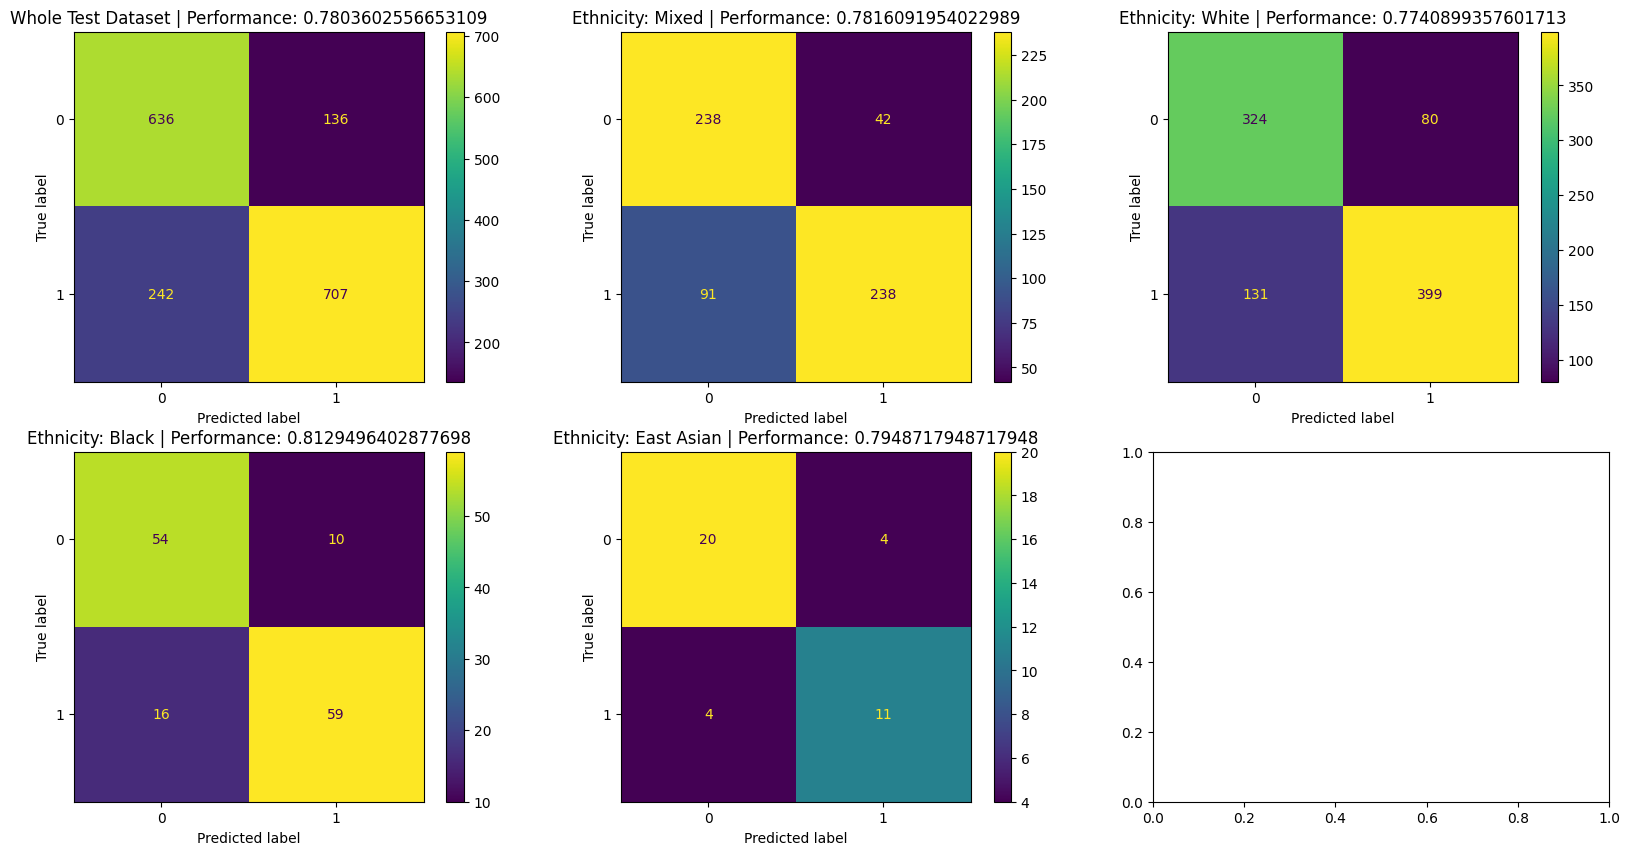

In [86]:
syn_y = decaf_syn_data["is_dead_at_time_horizon=14"]
syn_X_in = decaf_syn_data.drop(columns=["is_dead_at_time_horizon=14"])

syn_X_train, syn_X_test, syn_y_train, syn_y_test = train_test_split(syn_X_in, syn_y, random_state=4)
syn_X_train.reset_index(drop=True, inplace=True)
syn_X_test.reset_index(drop=True, inplace=True)
syn_y_train.reset_index(drop=True, inplace=True)
syn_y_test.reset_index(drop=True, inplace=True)

# Train model on whole dataset
xgb_model = xgb.XGBClassifier(
    n_estimators=2000,
    learning_rate=0.01,
    max_depth=5,
    subsample=0.8, 
    colsample_bytree=1, 
    gamma=1, 
    objective="binary:logistic",
    random_state=42,
)
xgb_model.fit(syn_X_train, syn_y_train)

ethnicity_idxes = syn_X_in["Ethnicity"].unique()
ethnicity_idxes.sort()
ethnicities = [ethnicity_mapper[e] for e in ethnicity_idxes]

calculated_accuracy_score = accuracy_score(syn_y_train, xgb_model.predict(syn_X_train))
print(f"evaluating train set: {calculated_accuracy_score}")
syn_y_pred = xgb_model.predict(syn_X_test)
calculated_accuracy_score = accuracy_score(syn_y_test, syn_y_pred)


f, axes = plt.subplots(2, 3, figsize=(20, 10))

cm = confusion_matrix(syn_y_test, syn_y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb_model.classes_)
disp.plot(ax=axes[0,0])
disp.ax_.set_title(f"Whole Test Dataset | Performance: {calculated_accuracy_score}")

for ethnicity_idx in ethnicity_idxes:
    syn_X_test_per_ethnicity = syn_X_test.loc[syn_X_test["Ethnicity"] == ethnicity_idx]
    test_records_per_ethnicity_indicies = syn_X_test_per_ethnicity.index

    syn_y_pred = xgb_model.predict(syn_X_test_per_ethnicity)
    syn_y_true = syn_y_test.iloc[test_records_per_ethnicity_indicies]

    calculated_accuracy_score = accuracy_score(syn_y_true, syn_y_pred)

    cm = confusion_matrix(syn_y_true, syn_y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=xgb_model.classes_)
    ax_index = [0, ethnicity_idx + 1] if ethnicity_idx <= 1 else [1, (ethnicity_idx + 1) % 3]
    disp.plot(ax=axes[ax_index[0], ax_index[1]])
    disp.ax_.set_title(f"Ethnicity: {ethnicity_mapper[ethnicity_idx]} | Performance: {calculated_accuracy_score}")
plt.show()